In [2]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling3D, Reshape, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_dim_ordering('tf')
from time import time
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
%matplotlib inline

Using TensorFlow backend.


In [4]:
def load_data():
    print('loading data...')
    start = time()
    #skeleton = np.loadtxt('rotational_data.csv',delimiter=',',dtype=np.float32)
    #skeleton.shape=(-1,30,3)
    frames = np.loadtxt('rep84580.csv',delimiter=',',dtype=np.float32)
    frames = frames.reshape(-1,8,45,80)
    print('Job completed in {} seconds'.format(time()-start))
    return frames
frames = load_data()
print(frames.shape)

loading data...
Job completed in 31.672126293182373 seconds
(2032, 8, 45, 80)


In [5]:
frames = frames.reshape(-1,8,45*80)
X = []
for f in frames:
    X.append(f.T.reshape(45,80,8))
X = np.array(X)
print(X.shape)

(2032, 45, 80, 8)


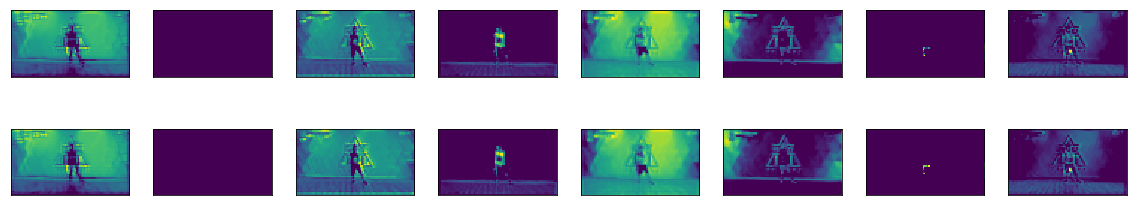

In [8]:
n=8
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    img = frames[0][i].reshape(45,80)
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    newimg = frames[1][i].reshape(45,80)
    plt.imshow(newimg)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
X.shape

(2032, 45, 80, 8)

In [11]:
videos = []
video = []
domain = [80,176,75,206,75,121,123,139,158,225,104,83,134,136,182]
domain = np.array(domain) + 1
print(domain)

di = 0
prev = 0
start = 0
see = domain[di]
do = True
for i,img in enumerate(X):
    if len(video) > 70:
        raise ValueError("ERROR video frames exceeding 70")
    if len(video) == 70:
        videos.append(video)
        start = i
        remain = 70-(see+prev-start)
        if not do:
            di += 1
            prev = see-1
            see = domain[di]
            video = []
            do = True
        if remain > 70:
            do = True
            video = []
        else:
            do = False
            video = video[-remain:]

    video.append(img)

videos = np.array(videos)
print(videos.shape)


[ 81 177  76 207  76 122 124 140 159 226 105  84 135 137 183]
(29, 70, 45, 80, 8)


In [12]:
#change to channel last before running

ts = 70
input_img = Input(shape=(ts,45,80,8))
e1 = ConvLSTM2D(40,(3,3),return_sequences=True,padding='same')(input_img)
e2 = BatchNormalization()(e1)
e3 = ConvLSTM2D(40,(3,3),return_sequences=True,padding='same')(e2)
e4 = BatchNormalization()(e3)
e5 = Flatten()(e4)
e6 = Reshape((1000,120,84))(e5)
e7 = Conv2D(16,(9, 9),activation='sigmoid',padding='same')(e6)
e8 = MaxPooling2D((1,2))(e7)
e9 = Conv2D(3,(3,3),activation='sigmoid',padding='same')(e8) #394 127 3
encoded = MaxPooling2D((1,2))(e9)

d0 = UpSampling2D((1,2))(encoded)
d1 = Conv2DTranspose(16,(3,3),padding='same')(d0)
d2 = UpSampling2D((1,2))(d1)
d3 = Conv2DTranspose(84,(9,9),padding='same',activation = 'relu')(d2)
d4 = Flatten()(d3)
d5= Reshape((70, 45, 80, 40))(d4)
d6 = ConvLSTM2D(40,(3,3),return_sequences=True,padding='same')(d5)
d7 = BatchNormalization()(d6)
decoded = ConvLSTM2D(8,(3,3),return_sequences=True,padding='same')(d7)


nmodel = Model(input_img, decoded)
nmodel.compile(optimizer='adadelta',loss='binary_crossentropy')
nmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70, 45, 80, 8)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 70, 45, 80, 40)    69280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 45, 80, 40)    160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 70, 45, 80, 40)    115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 45, 80, 40)    160       
_________________________________________________________________
flatten_1 (Flatten)          (None, 10080000)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 120, 84)     0         
__________

In [17]:
train = videos[:25]
test = videos[25:]

In [ ]:
nmodel.fit(train,train, epochs=30, batch_size=2, 
                validation_data=(test,test),
                callbacks=[TensorBoard(log_dir='/tmp/convlstm')])

Train on 25 samples, validate on 4 samples
Epoch 1/30


In [ ]:
tbCallBack = TensorBoard(log_dir='./ConvLSTM', histogram_freq=0, write_graph=True, write_images=True)
nmodel.fit(train,train, epochs=150, batch_size=4, 
                validation_data=(test,test),
                callbacks=[tbCallBack])